**Feature Extraction :**
It uses the representations learned by the pre-trained network to extract meaningful features for new samples of a specific task. At this point, you can simply add a new classifier, which will be trained from scratch but on top the pre-trained model, so that you can reuse the feature map learned previously. Specifically, the pre-trained model’s parameters are kept frozen during training on the target task. This way you do not need to retrain the whole (more complex) model because the base network already contains features that are generally useful for different specific tasks.

In [1]:
!nvidia-smi

Fri Jul  5 14:11:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# get data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-07-05 14:11:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.1MB/s    in 8.3s    

2024-07-05 14:11:23 (19.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

for dirpath, dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

# Prepairing the data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode =  "categorical")

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode =  "categorical")



Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [7]:
# Create tensorboard callback
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback


## Creating models using TensorFlow Hub

In [8]:
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"



In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
def create_model(model_url,num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           input_shape = IMAGE_SHAPE + (3,))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax")
  ])

  return model

## ResNet Model

In [11]:
resnet_model =  create_model(resnet_url,num_classes = train_data_10_percent.num_classes)

In [12]:
resnet_model.compile(loss = "categorical_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ["accuracy"])

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23581642 (89.96 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23561152 (89.88 MB)
_________________________________________________________________


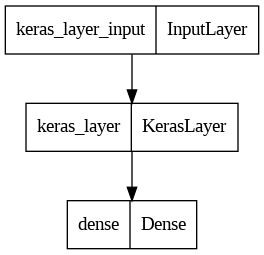

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(resnet_model)

In [13]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps = len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                           experiment_name="Resnetv2")])


Saving TensorBoard log files to : tensorflow_hub/Resnetv2/20240705-141314
Epoch 1/5
24/24 [==============================] - 26s 678ms/step - loss: 1.8275 - accuracy: 0.4080 - val_loss: 1.0380 - val_accuracy: 0.6820
Epoch 2/5
24/24 [==============================] - 11s 487ms/step - loss: 0.7737 - accuracy: 0.7680 - val_loss: 0.7007 - val_accuracy: 0.7932
Epoch 3/5
24/24 [==============================] - 11s 476ms/step - loss: 0.5197 - accuracy: 0.8547 - val_loss: 0.6482 - val_accuracy: 0.7932
Epoch 4/5
24/24 [==============================] - 13s 551ms/step - loss: 0.3996 - accuracy: 0.8987 - val_loss: 0.6021 - val_accuracy: 0.8140
Epoch 5/5
24/24 [==============================] - 13s 547ms/step - loss: 0.3130 - accuracy: 0.9413 - val_loss: 0.5882 - val_accuracy: 0.8120


<Axes: >

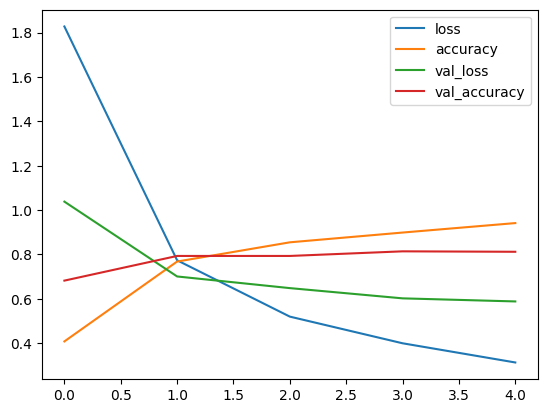

In [14]:
import pandas as pd

pd.DataFrame(resnet_history.history).plot()

In [15]:
resnet_model.evaluate(test_data_10_percent)

79/79 [==============================] - 9s 113ms/step - loss: 0.5882 - accuracy: 0.8120


[0.5881637930870056, 0.8119999766349792]

In [16]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs,loss,label="traning_loss")
  plt.plot(epochs,val_loss,label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="traning_accuracy")
  plt.plot(epochs,val_accuracy,label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



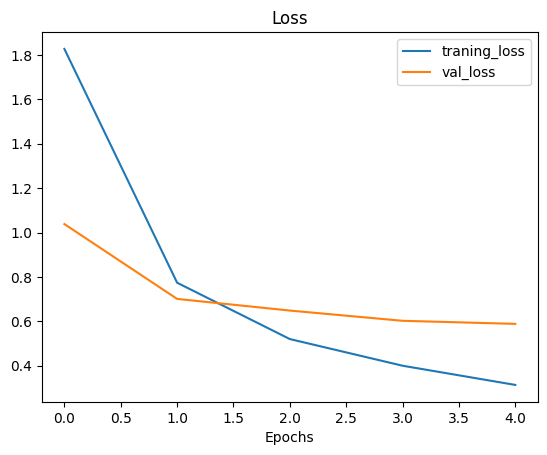

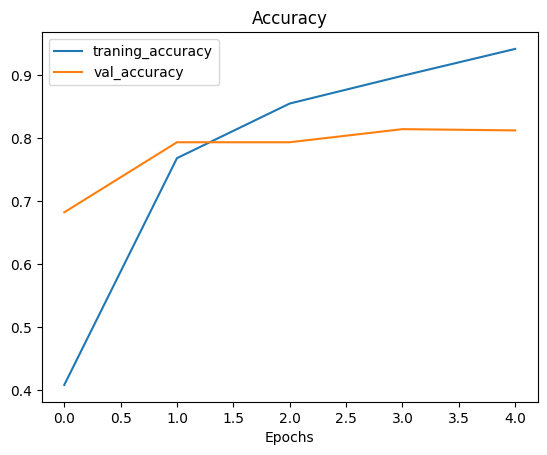

In [19]:
plot_loss_curves(resnet_history)

## EfficientNet

In [21]:
efficient_net = create_model(efficientnet_url,num_classes = train_data_10_percent.num_classes)

In [22]:
efficient_net.compile(loss="categorical_crossentropy",
                      optimizer="Adam",
                      metrics=["accuracy"])

In [23]:
efficient_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [25]:
efficient_net_history = efficient_net.fit(train_data_10_percent,
                                          epochs=5,
                                          steps_per_epoch = len(train_data_10_percent),
                                          validation_data = test_data_10_percent,
                                          validation_steps = len(test_data_10_percent),
                                          callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                   experiment_name="EfficientNet")])

Saving TensorBoard log files to : tensorflow_hub/EfficientNet/20240705-142901
Epoch 1/5
24/24 [==============================] - 26s 573ms/step - loss: 1.8033 - accuracy: 0.4667 - val_loss: 1.2572 - val_accuracy: 0.7592
Epoch 2/5
24/24 [==============================] - 13s 540ms/step - loss: 1.0390 - accuracy: 0.7680 - val_loss: 0.8511 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 13s 540ms/step - loss: 0.7475 - accuracy: 0.8387 - val_loss: 0.6876 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 10s 433ms/step - loss: 0.6050 - accuracy: 0.8680 - val_loss: 0.6042 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 13s 547ms/step - loss: 0.5082 - accuracy: 0.9013 - val_loss: 0.5520 - val_accuracy: 0.8612


In [27]:
efficient_net.evaluate(test_data_10_percent)

79/79 [==============================] - 8s 106ms/step - loss: 0.5520 - accuracy: 0.8612


[0.5520277619361877, 0.8611999750137329]

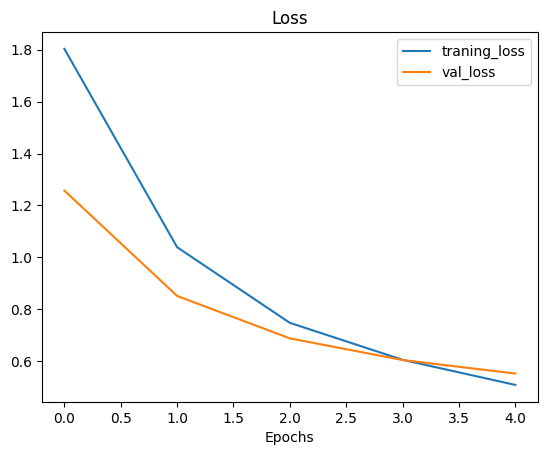

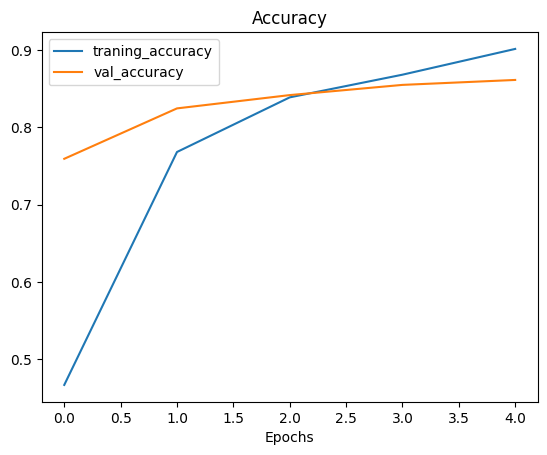

In [28]:
plot_loss_curves(efficient_net_history)

In [29]:
resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23581642 (89.96 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23561152 (89.88 MB)
_________________________________________________________________


In [30]:
efficient_net.summary() # Better perform even number of parameters is less

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________
